# Ice Classification in the Groenland

## Package

In [1]:
# Usual package
import pandas as pd 
import numpy as np

# Packages for data visualization
import matplotlib.pyplot as plt  # plotting graphs and visualizations
import seaborn as sns  # heatmaps and boxplots

# Scikit-learn packages for data preprocessing, model training, and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
# train_test_split: For splitting data into training and testing sets
# RandomizedSearchCV: For hyperparameter tuning via random search
# cross_val_score: For model evaluation using cross-validation
# StratifiedKFold: For stratified cross-validation ensuring each fold is representative of the class distribution

from sklearn.preprocessing import StandardScaler  # For standardizing data to have mean 0 and variance 1
from sklearn.decomposition import PCA  # For reducing dimensionality using Principal Component Analysis

# Feature selection method
from sklearn.feature_selection import SelectKBest, f_classif
# SelectKBest: For selecting the best features based on a scoring function
# f_classif: ANOVA F-value between label and feature for classification tasks

# Evaluation metrics for classification performance
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
# accuracy_score: For measuring the proportion of correct predictions
# f1_score, recall_score, precision_score: For measuring various aspects of model performance on classification
# roc_auc_score: For evaluating the area under the ROC curve for binary classifiers
# roc_curve: For plotting the Receiver Operating Characteristic (ROC) curve

# Classification algorithms
from sklearn.linear_model import LogisticRegression  # For linear classification using logistic regression
from sklearn.neighbors import KNeighborsClassifier  # For classification based on K-Nearest Neighbors
from sklearn.naive_bayes import GaussianNB  # For Naive Bayes classification (Gaussian distribution)
from sklearn.svm import SVC  # For Support Vector Classification (SVM)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
# RandomForestClassifier: For ensemble classification with multiple decision trees
# AdaBoostClassifier: For boosting-based classification
# GradientBoostingClassifier: For gradient-boosted trees classification
# ExtraTreesClassifier: For ensemble classification using extremely randomized trees

# Gradient boosting libraries for optimized gradient-boosted trees
from xgboost import XGBClassifier  # For gradient boosting using XGBoost
from lightgbm import LGBMClassifier  # For gradient boosting using LightGBM

# Pipeline for chaining transformations and estimators
from sklearn.pipeline import Pipeline  # For creating a pipeline of transformations and a model

## Data

In [3]:
features = pd.read_csv('data_Features.csv')
targets = pd.read_csv('data_Targets.csv')

In [5]:
features.head(5)

,time,t2m,u10,v10,SST,SIC,r1_MAR,r2_MAR,r3_MAR,r4_MAR,r5_MAR
0,2013-01-01,-21.926931,-0.973994,3.149094,-1.690511,90.745710,0.034537,0.033345,0.0,0.0,0.0
1,2013-01-02,-23.696195,-6.502908,2.494894,-1.690511,88.502980,0.034527,0.033326,0.0,0.0,0.0
2,2013-01-03,-25.644027,-3.557411,1.025486,-1.689860,88.734091,0.034523,0.033321,0.0,0.0,0.0
3,2013-01-04,-23.566887,-1.888075,-3.486122,-1.690511,89.149576,0.034509,0.033306,0.0,0.0,0.0
4,2013-01-05,-22.897768,-2.748844,-3.491206,-1.689860,91.613955,0.034492,0.033290,0.0,0.0,0.0


In [7]:
targets.head(5)

,Unnamed: 0,Y1,Y3,Y4,Y5
0,2013-01-01,0,5,0,0
1,2013-01-02,0,0,0,0
2,2013-01-03,0,0,0,0
3,2013-01-04,0,2,0,0
4,2013-01-05,0,0,0,0


In [9]:
# We rename target column for clarity
targets.columns.values[0] = 'time'
targets.head(5)

,time,Y1,Y3,Y4,Y5
0,2013-01-01,0,5,0,0
1,2013-01-02,0,0,0,0
2,2013-01-03,0,0,0,0
3,2013-01-04,0,2,0,0
4,2013-01-05,0,0,0,0


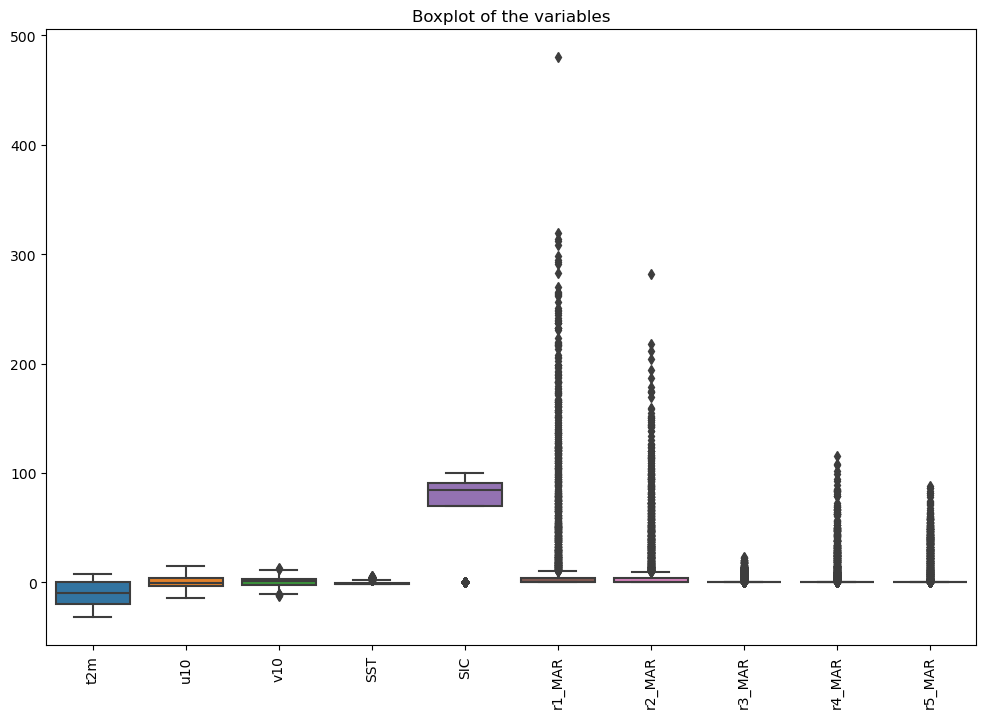

In [11]:
# We do a boxplot to have a better vision of the data repartition
plt.figure(figsize=(12, 8))
sns.boxplot(data=features)
plt.title("Boxplot of the variables")
plt.xticks(rotation=90)
plt.show()

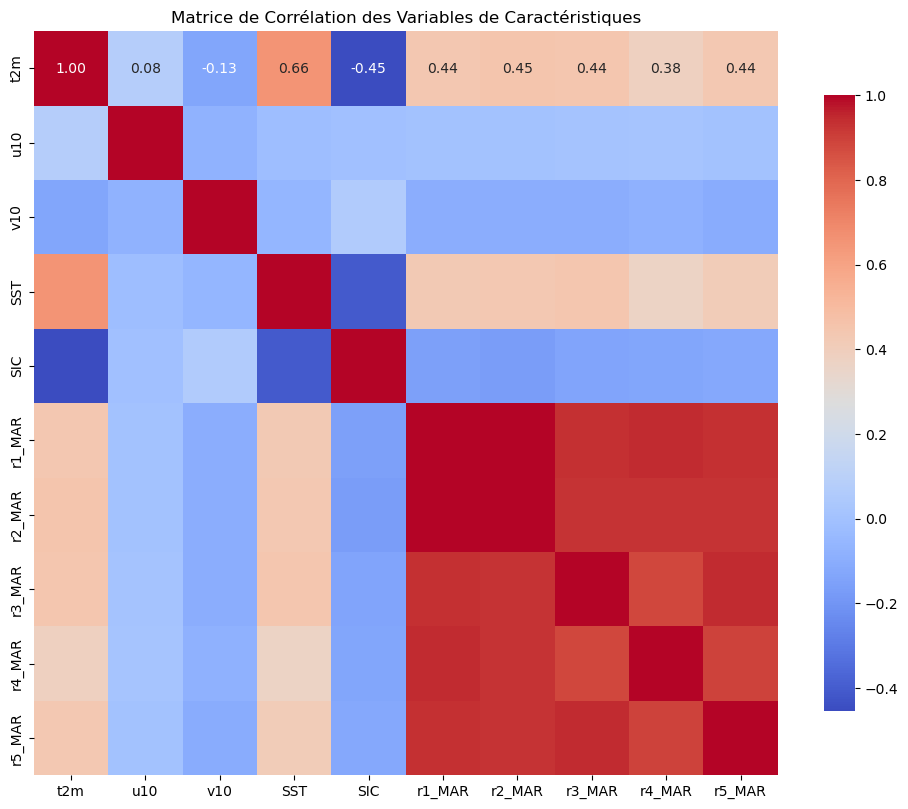

In [29]:
# We do the correlation matrix to see if we can do a PCA
correlation_matrix = features.iloc[:, 1:].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of the varaibles")
plt.show()

In [ ]:
# We see a high correlation for the variables MAR (r1, r2, r3, r4, r5), it give us the idea to try a PCA

## Project

In [43]:
# Binarize target based on the mean, mean+std and 90% quantile
# The explanation for the mean is intuitive
Y1 = targets['Y1']
threshold_1, threshold_2, threshold_3  = Y1.mean(), Y1.mean() + Y1.std(), Y1.quantile(0.9)
Y_binary_1,Y_binary_2,Y_binary_3 = (Y1 >= threshold_1).astype(int), (Y1 >= threshold_2).astype(int), (Y1 >= threshold_3).astype(int)

In [45]:
X = features.drop(columns=['time'])
y1, y2, y3 = Y_binary_1, Y_binary_2, Y_binary_3

In [47]:
# We split data into training and testing sets
test_size = 0.3

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y1, test_size = test_size, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, test_size = test_size, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y3, test_size = test_size, random_state=42)

In [51]:
# We standardize the data 
scaler = StandardScaler()

X_train_scaled_1, X_train_scaled_2, X_train_scaled_3 = scaler.fit_transform(X_train_1), scaler.fit_transform(X_train_2), scaler.fit_transform(X_train_3)
X_test_scaled_1, X_test_scaled_2, X_test_scaled_3 = scaler.transform(X_test_1), scaler.transform(X_test_2), scaler.transform(X_test_3)

In [53]:
# We do the PCA transformation
pca = PCA(n_components=5)

X_train_pca_1 = pca.fit_transform(X_train_scaled_1)
X_train_pca_2 = pca.fit_transform(X_train_scaled_2)
X_train_pca_3 = pca.fit_transform(X_train_scaled_3)

X_test_pca_1 = pca.transform(X_test_scaled_1)
X_test_pca_2 = pca.transform(X_test_scaled_2)
X_test_pca_3 = pca.transform(X_test_scaled_3)

In [55]:
# Now we do the Supervised Principal Components (SPC) transformation
spc_pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=f_classif, k=10)),  # Select top features correlated with the target
    ("pca", PCA(n_components=5))  # Reduce to 5 SPCs
])

X_train_spc_1 = spc_pipeline.fit_transform(X_train_scaled_1, y_train_1)
X_train_spc_2 = spc_pipeline.fit_transform(X_train_scaled_2, y_train_2)
X_train_spc_3 = spc_pipeline.fit_transform(X_train_scaled_3, y_train_3)

X_test_spc_1 = spc_pipeline.transform(X_test_scaled_1)
X_test_spc_2 = spc_pipeline.transform(X_test_scaled_2)
X_test_spc_3 = spc_pipeline.transform(X_test_scaled_3)

In [57]:
# We do the Stratified K-Fold cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [59]:
# We define the models and the parameter grids
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

param_grid = {
    "Logistic Regression": {"C": [0.001, 0.01, 0.1, 1, 10]},
    "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7, 10, 12]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [10, 20, 30]},
    "Extra Trees": {"n_estimators": [100, 200, 300], "max_depth": [10, 20, 30]},
    "AdaBoost": {"n_estimators": [50, 100, 200]},
    "Gradient Boosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    "LightGBM": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "num_leaves": [31, 40, 50]}
}

In [65]:
# We define a function to evaluate the model
def evaluate_models(X_train, X_test, y_train, y_test, data_type="Standard"):
    results = []
    for model_name, model in models.items():
        # Hyperparameter optimization
        if model_name in param_grid:
            search = RandomizedSearchCV(model, param_grid[model_name], n_iter=3, scoring="roc_auc", cv=cv, random_state=42)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params = search.best_params_
        else:
            best_model = model
            best_model.fit(X_train, y_train)
            best_params = "Default"

        # Cross-validation scores
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc')
        mean_cv_score = np.mean(cv_scores)

        # Predictions
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

        # Performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

        results.append({
            "Model": model_name,
            "Data Type": data_type,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Recall": recall,
            "Precision": precision,
            "AUC-ROC": auc,
            "Cross-Validation AUC-ROC": mean_cv_score,
            "Best Hyperparameters": best_params
        })
    return results

In [67]:
# Now, we evaluate the models on standard data, PCA-transformed data and SPC-transformed data
results_standard_1 = evaluate_models(X_train_scaled_1, X_test_scaled_1, y_train_1, y_test_1, "Standard")
results_pca_1 = evaluate_models(X_train_pca_1, X_test_pca_1, y_train_1, y_test_1, "PCA")
results_spc_1 = evaluate_models(X_train_spc_1, X_test_spc_1, y_train_1, y_test_1, "SPC")

results_standard_2 = evaluate_models(X_train_scaled_2, X_test_scaled_2, y_train_2, y_test_2, "Standard")
results_pca_2 = evaluate_models(X_train_pca_2, X_test_pca_2, y_train_2, y_test_2, "PCA")
results_spc_2 = evaluate_models(X_train_spc_2, X_test_spc_2, y_train_2, y_test_2, "SPC")

results_standard_3 = evaluate_models(X_train_scaled_3, X_test_scaled_3, y_train_3, y_test_3, "Standard")
results_pca_3 = evaluate_models(X_train_pca_3, X_test_pca_3, y_train_3, y_test_3, "PCA")
results_spc_3 = evaluate_models(X_train_spc_3, X_test_spc_3, y_train_3, y_test_3, "SPC")

[LightGBM] [Info] Number of positive: 116, number of negative: 1315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 1431, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081062 -> initscore=-2.428002
[LightGBM] [Info] Start training from score -2.428002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [68]:
# Result for the mean treshold
results_df_1 = pd.DataFrame(results_standard_1 + results_pca_1 + results_spc_1)
print(results_df_1)

                  Model Data Type  Accuracy  F1 Score    Recall  Precision  \
0   Logistic Regression  Standard  0.963494  0.714286  0.625000   0.833333   
1   K-Nearest Neighbors  Standard  0.970013  0.792793  0.785714   0.800000   
2           Naive Bayes  Standard  0.954368  0.744526  0.910714   0.629630   
3                   SVM  Standard  0.968709  0.769231  0.714286   0.833333   
4         Random Forest  Standard  0.971317  0.803571  0.803571   0.803571   
5           Extra Trees  Standard  0.973924  0.824561  0.839286   0.810345   
6              AdaBoost  Standard  0.971317  0.803571  0.803571   0.803571   
7     Gradient Boosting  Standard  0.960887  0.736842  0.750000   0.724138   
8               XGBoost  Standard  0.967405  0.770642  0.750000   0.792453   
9              LightGBM  Standard  0.971317  0.803571  0.803571   0.803571   
10  Logistic Regression       PCA  0.966102  0.740000  0.660714   0.840909   
11  K-Nearest Neighbors       PCA  0.964798  0.761062  0.767857 

In [71]:
# Result for the mean+std treshold
results_df_2 = pd.DataFrame(results_standard_2 + results_pca_2 + results_spc_2)
print(results_df_2)

                  Model Data Type  Accuracy  F1 Score    Recall  Precision  \
0   Logistic Regression  Standard  0.970013  0.610169  0.620690   0.600000   
1   K-Nearest Neighbors  Standard  0.979140  0.714286  0.689655   0.740741   
2           Naive Bayes  Standard  0.943937  0.565657  0.965517   0.400000   
3                   SVM  Standard  0.972621  0.618182  0.586207   0.653846   
4         Random Forest  Standard  0.980443  0.736842  0.724138   0.750000   
5           Extra Trees  Standard  0.979140  0.714286  0.689655   0.740741   
6              AdaBoost  Standard  0.970013  0.610169  0.620690   0.600000   
7     Gradient Boosting  Standard  0.975228  0.558140  0.413793   0.857143   
8               XGBoost  Standard  0.975228  0.677966  0.689655   0.666667   
9              LightGBM  Standard  0.979140  0.714286  0.689655   0.740741   
10  Logistic Regression       PCA  0.964798  0.425532  0.344828   0.555556   
11  K-Nearest Neighbors       PCA  0.967405  0.528302  0.482759 

In [73]:
# Result for the 90% quantile treshold
results_df_3 = pd.DataFrame(results_standard_3 + results_pca_3 + results_spc_3)
print(results_df_3)

                  Model Data Type  Accuracy  F1 Score  Recall  Precision  \
0   Logistic Regression  Standard  0.950456  0.739726  0.6750   0.818182   
1   K-Nearest Neighbors  Standard  0.954368  0.758621  0.6875   0.846154   
2           Naive Bayes  Standard  0.928292  0.682081  0.7375   0.634409   
3                   SVM  Standard  0.943937  0.686131  0.5875   0.824561   
4         Random Forest  Standard  0.949153  0.727273  0.6500   0.825397   
5           Extra Trees  Standard  0.945241  0.716216  0.6625   0.779412   
6              AdaBoost  Standard  0.947849  0.726027  0.6625   0.803030   
7     Gradient Boosting  Standard  0.940026  0.684932  0.6250   0.757576   
8               XGBoost  Standard  0.943937  0.699301  0.6250   0.793651   
9              LightGBM  Standard  0.943937  0.703448  0.6375   0.784615   
10  Logistic Regression       PCA  0.942634  0.676471  0.5750   0.821429   
11  K-Nearest Neighbors       PCA  0.949153  0.731034  0.6625   0.815385   
12          

[LightGBM] [Info] Number of positive: 116, number of negative: 1315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 1431, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081062 -> initscore=-2.428002
[LightGBM] [Info] Start training from score -2.428002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

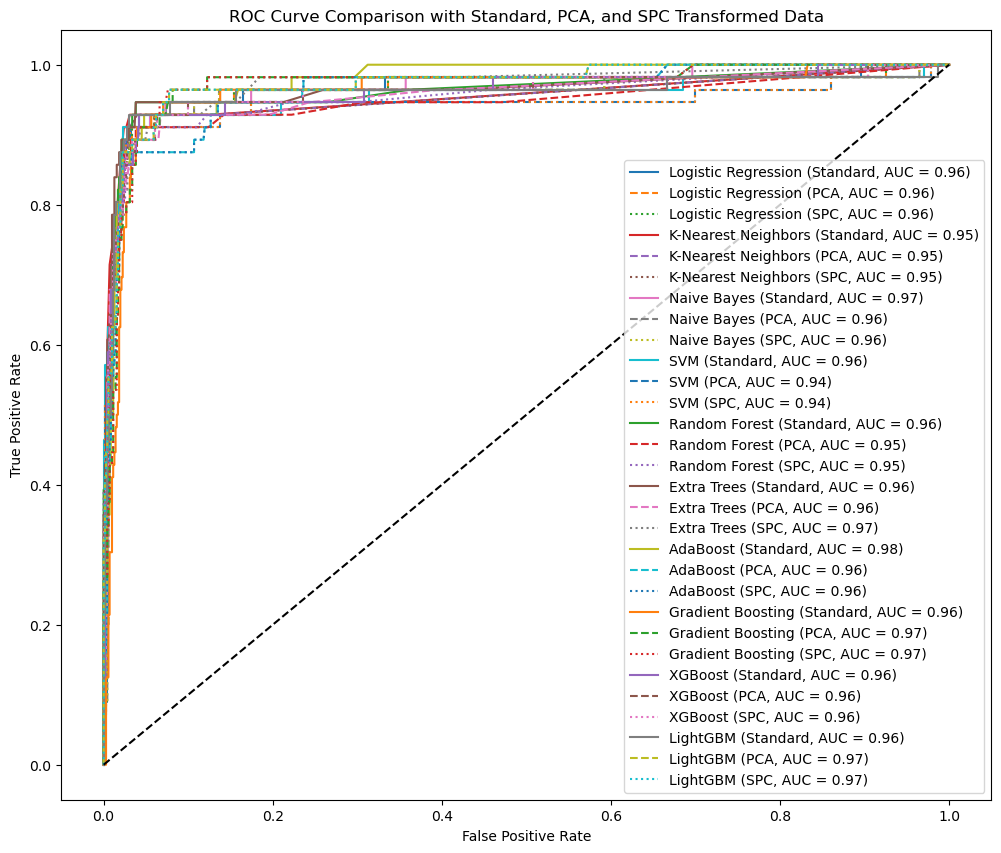

In [77]:
# We get the ROC curve to compare with a mean treshold 
plt.figure(figsize=(12, 10))
for model_name, model in models.items():
    # Without PCA or SPC
    if model_name in param_grid:
        best_model = RandomizedSearchCV(model, param_grid[model_name], n_iter=3, scoring="roc_auc", cv=cv, random_state=42).fit(X_train_scaled_1, y_train_1).best_estimator_
    else:
        best_model = model.fit(X_train_scaled_1, y_train_1)
    
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test_scaled_1)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_1, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (Standard, AUC = {roc_auc_score(y_test_1, y_proba):.2f})")
    
    # With PCA
    best_model.fit(X_train_pca_1, y_train_1)
    if hasattr(best_model, "predict_proba"):
        y_proba_pca = best_model.predict_proba(X_test_pca_1)[:, 1]
        fpr_pca, tpr_pca, _ = roc_curve(y_test_1, y_proba_pca)
        plt.plot(fpr_pca, tpr_pca, linestyle='--', label=f"{model_name} (PCA, AUC = {roc_auc_score(y_test_1, y_proba_pca):.2f})")
    
    # With SPC
    best_model.fit(X_train_spc_1, y_train_1)
    if hasattr(best_model, "predict_proba"):
        y_proba_spc = best_model.predict_proba(X_test_spc_1)[:, 1]
        fpr_spc, tpr_spc, _ = roc_curve(y_test_1, y_proba_spc)
        plt.plot(fpr_spc, tpr_spc, linestyle=':', label=f"{model_name} (SPC, AUC = {roc_auc_score(y_test_1, y_proba_spc):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison with Standard, PCA, and SPC Transformed Data")
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 63, number of negative: 1368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 1431, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044025 -> initscore=-3.077970
[LightGBM] [Info] Start training from score -3.077970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

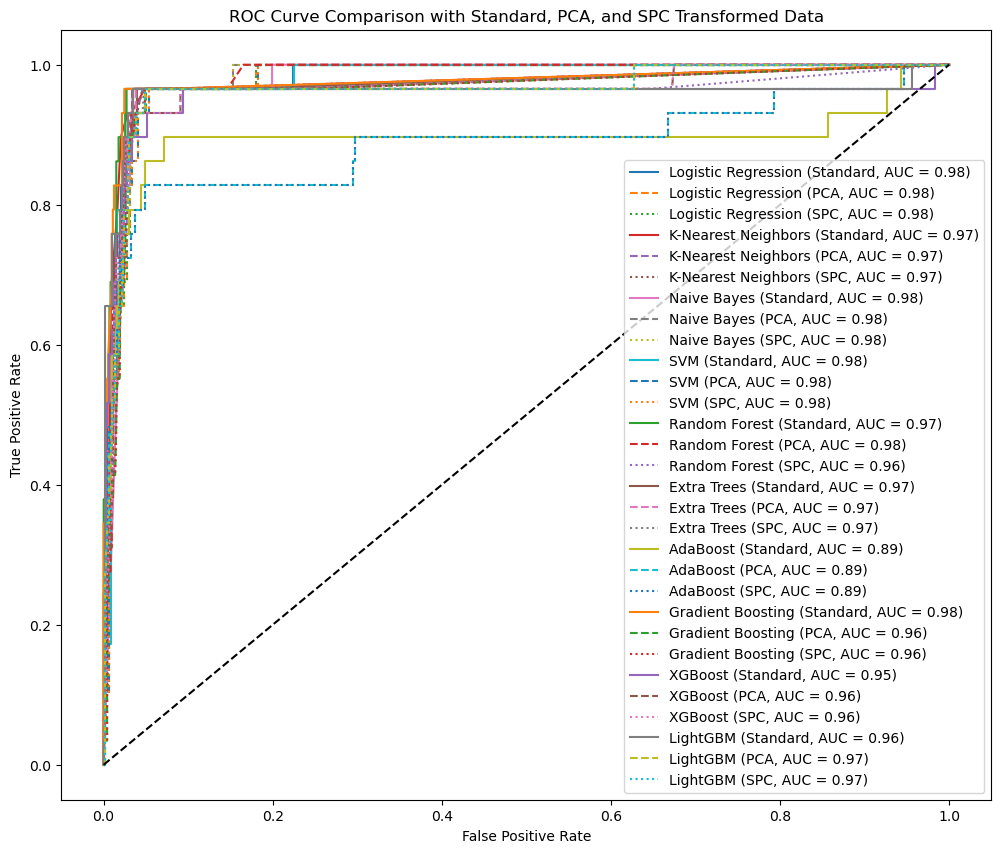

In [79]:
# We get the ROC curve to compare with a mean+std treshold 
plt.figure(figsize=(12, 10))
for model_name, model in models.items():
    # Without PCA or SPC
    if model_name in param_grid:
        best_model = RandomizedSearchCV(model, param_grid[model_name], n_iter=3, scoring="roc_auc", cv=cv, random_state=42).fit(X_train_scaled_2, y_train_2).best_estimator_
    else:
        best_model = model.fit(X_train_scaled_2, y_train_2)
    
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test_scaled_2)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_2, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (Standard, AUC = {roc_auc_score(y_test_2, y_proba):.2f})")
    
    # With PCA
    best_model.fit(X_train_pca_2, y_train_2)
    if hasattr(best_model, "predict_proba"):
        y_proba_pca = best_model.predict_proba(X_test_pca_2)[:, 1]
        fpr_pca, tpr_pca, _ = roc_curve(y_test_2, y_proba_pca)
        plt.plot(fpr_pca, tpr_pca, linestyle='--', label=f"{model_name} (PCA, AUC = {roc_auc_score(y_test_2, y_proba_pca):.2f})")
    
    # With SPC
    best_model.fit(X_train_spc_2, y_train_2)
    if hasattr(best_model, "predict_proba"):
        y_proba_spc = best_model.predict_proba(X_test_spc_2)[:, 1]
        fpr_spc, tpr_spc, _ = roc_curve(y_test_2, y_proba_spc)
        plt.plot(fpr_spc, tpr_spc, linestyle=':', label=f"{model_name} (SPC, AUC = {roc_auc_score(y_test_2, y_proba_spc):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison with Standard, PCA, and SPC Transformed Data")
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 171, number of negative: 1260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2113
[LightGBM] [Info] Number of data points in the train set: 1431, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119497 -> initscore=-1.997203
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

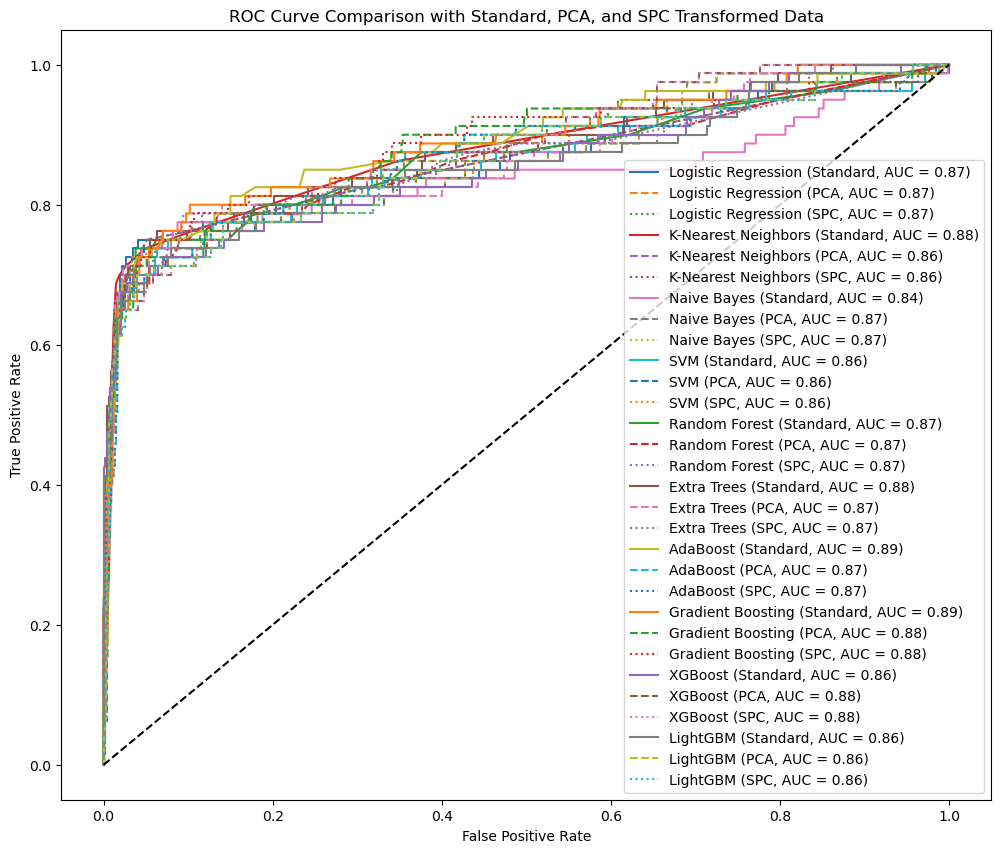

In [81]:
# We get the ROC curve to compare with a 90% quantile treshold 
plt.figure(figsize=(12, 10))
for model_name, model in models.items():
    # Without PCA or SPC
    if model_name in param_grid:
        best_model = RandomizedSearchCV(model, param_grid[model_name], n_iter=3, scoring="roc_auc", cv=cv, random_state=42).fit(X_train_scaled_3, y_train_3).best_estimator_
    else:
        best_model = model.fit(X_train_scaled_3, y_train_3)
    
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test_scaled_3)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_3, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (Standard, AUC = {roc_auc_score(y_test_3, y_proba):.2f})")
    
    # With PCA
    best_model.fit(X_train_pca_3, y_train_3)
    if hasattr(best_model, "predict_proba"):
        y_proba_pca = best_model.predict_proba(X_test_pca_3)[:, 1]
        fpr_pca, tpr_pca, _ = roc_curve(y_test_3, y_proba_pca)
        plt.plot(fpr_pca, tpr_pca, linestyle='--', label=f"{model_name} (PCA, AUC = {roc_auc_score(y_test_3, y_proba_pca):.2f})")
    
    # With SPC
    best_model.fit(X_train_spc_3, y_train_3)
    if hasattr(best_model, "predict_proba"):
        y_proba_spc = best_model.predict_proba(X_test_spc_3)[:, 1]
        fpr_spc, tpr_spc, _ = roc_curve(y_test_3, y_proba_spc)
        plt.plot(fpr_spc, tpr_spc, linestyle=':', label=f"{model_name} (SPC, AUC = {roc_auc_score(y_test_3, y_proba_spc):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison with Standard, PCA, and SPC Transformed Data")
plt.legend(loc="lower right")
plt.show()